# Applied Data Science Capstone
### This notebook is the final project of IBM's Data Science Professional Certificate

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion) 

## Introduction <a name="introduction"></a>

For many people, the search for an excellent area to live is an arduous process of investigation into the different areas of one city. The definition of a good area to live into varies from one person to another and so the search for a house or an appartment is in the same way unique to the individual.
 
In this project we will try to find an optimal neighborhood for a fictional client. This client will have some criteria that will define their ideal area to live in Paris (France). For the purpose of simplicity we are going to take only three elements into account for this fictional user:

* The appartment should be near of a pharmacy
* It should also have a supermarket nearby
* And it should not be far from a metro or train station

## Data <a name="data"></a>

Based on the problem we are trying to solve we will need geospatial data such as the list of neighborhoods in Paris and their latitude and longitude coordinates. Also, we will need venue data in relation to the criteria of the ideal area to live given by the user.

Following data sources will be needed to extract/generate the required information:
* coordinate of each parisian borough will be extracted from the French government's **[Open Platform for French Public Data](https://www.data.gouv.fr/en/datasets/quartiers-administratifs/)**
* number of bakeries, supermarkets and metro stations and location in every neighborhood will be obtained using **Yelp API**



### *Quartiers* of Paris: visual representation

In order to visualize in a map the limits of each borough of Paris, first of all we are going to extract the data of their shapes and coordinates from the French government's database.

In [1]:
# Let's import all the necessary packages to work with our data

import numpy as np
import pandas as pd
import shapely
import descartes
import geopandas as gpd
import json
import os
import requests
import folium
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

# Let's import the dataset of the parisian boroughs' coordinates as a dataframe with geopandas

boroughs_url = 'https://www.data.gouv.fr/es/datasets/r/a8748f53-5850-4a04-b8cc-9c9f5f72949f'
boroughs = gpd.read_file(boroughs_url)
boroughs.head()

,n_sq_qu,n_sq_ar,c_qu,surface,l_qu,perimetre,c_quinsee,c_ar,geometry
0,750000048,750000012,48,1.235916e+06,Quinze-Vingts,4509.486974,7511204,12,"POLYGON ((2.37320 48.84057, 2.37241 48.84017, ..."
1,750000007,750000002,7,2.781426e+05,Mail,2179.153605,7510203,2,"POLYGON ((2.34684 48.86491, 2.34668 48.86443, ..."
2,750000008,750000002,8,2.814482e+05,Bonne-Nouvelle,2233.976030,7510204,2,"POLYGON ((2.35152 48.86443, 2.35095 48.86341, ..."
3,750000050,750000013,50,3.044178e+06,Gare,7070.350567,7511302,13,"POLYGON ((2.36771 48.81742, 2.36696 48.81719, ..."
4,750000070,750000018,70,1.653715e+06,Clignancourt,6005.520389,7511802,18,"POLYGON ((2.35168 48.89139, 2.35145 48.89043, ..."


This dataset gives us an overview of how the boroughs in Paris are shaped. In fact, they are shaped as polygons and there are 80 of them. In order to be able to work better on this data we are going to add centroids to each borough which will serve us to look for venues around them. 

In [2]:
# Let's create a new dataset with geopandas adding centroids to each borough

boroughs = gpd.GeoDataFrame.from_features(boroughs)
boroughs['centroid_lon'] = boroughs['geometry'].centroid.x
boroughs['centroid_lat'] = boroughs['geometry'].centroid.y
boroughs = boroughs.sort_values(by=['l_qu'])
boroughs.crs = {'init': 'epsg:4326'}
boroughs.to_csv(path_or_buf='boroughs.csv')
pd.read_csv('boroughs.csv')

,Unnamed: 0,geometry,c_ar,c_qu,c_quinsee,l_qu,n_sq_ar,n_sq_qu,perimetre,surface,centroid_lon,centroid_lat
0,15,"POLYGON ((2.409402172235365 48.88019204178156,...",19,75,7511903,Amérique,750000019,750000075,6399.022082,1.835720e+06,2.395440,48.881638
1,17,"POLYGON ((2.368479720528894 48.85583081045625,...",3,11,7510303,Archives,750000003,750000011,2534.100042,3.677284e+05,2.363205,48.859192
2,6,"POLYGON ((2.368512371393433 48.85573412813671,...",4,15,7510403,Arsenal,750000004,750000015,2878.559656,4.872649e+05,2.364768,48.851585
3,16,"POLYGON ((2.360209979547445 48.86519024025307,...",3,9,7510301,Arts-et-Métiers,750000003,750000009,2482.460453,3.180877e+05,2.357083,48.866470
4,37,"POLYGON ((2.249224929777843 48.85782761493475,...",16,61,7511601,Auteuil,750000016,750000061,12452.253931,6.383888e+06,2.252277,48.850622
...,...,...,...,...,...,...,...,...,...,...,...,...
75,45,"POLYGON ((2.349244542106854 48.84451631667142,...",5,20,7510504,Sorbonne,750000005,750000020,2892.944068,4.331978e+05,2.345747,48.849045
76,41,"POLYGON ((2.295039618663717 48.87377869547586,...",17,65,7511701,Ternes,750000017,750000065,5264.597082,1.465071e+06,2.289964,48.881178
77,61,"POLYGON ((2.34548425335897 48.8450733693259, 2...",5,19,7510503,Val-de-Grâce,750000005,750000019,3485.831358,7.036312e+05,2.343861,48.841684
78,53,"POLYGON ((2.370498649617153 48.87819784234086,...",19,73,7511901,Villette,750000019,750000073,5191.018830,1.285705e+06,2.374468,48.887661


In this project we will direct our efforts on finding a borough that fits the criteria of our given client. We will consider the one that has the more venues related to the client's needs as the best borough for them.

First of all, we are going to collect the data required for our analysis: location of every pharmacy, supermarket and metro station within every *quartier* in the city of Paris. 

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("API_KEY")
secret_value_1 = user_secrets.get_secret("appID")
headers = {'Authorization': 'Bearer %s' % secret_value_0}

In [4]:
# Let's build a new dataframe with the venues that match the criteria of our client

# We create two functions to retrieve the data from Yelp's website

url = 'https://api.yelp.com/v3/businesses/search?'

category = ['pharmacy', 'grocery', 'metrostations']
categories = ','.join(category)

# The first function will create all the API url requests

def defparams(lat, lon, radius, categories):
    params = {}
    params['latitude'] = lat
    params['longitude'] = lon
    params['radius'] = 1000
    params['categories'] = categories
    params['limit']=50
    return params

# This function will iterate through each borough to find nearby venues according to the defined criteria
names = boroughs['l_qu']
latitudes = boroughs['centroid_lat']
longitudes = boroughs['centroid_lon']

def getnearbyvenues (names, latitudes, longitudes, radius=1000, limit=50):
    venues_list = []
    for name, lat, lon in zip(names, latitudes, longitudes):
        params = defparams(lat, lon, radius, categories)
        results = requests.get(url=url, params=params, headers=headers).json()['businesses']
        
        for item in results:
            venue_name = item['name']
            venue_category = item['categories'][0]['title']
            venue_lat = item['coordinates']['latitude']
            venue_lon = item['coordinates']['longitude']
            try:
                venue_city = item['location']['city']
            except:
                venue_city = 'N/A'
            venues_list.append([(name,
                                lat,
                                lon,
                                venue_name,
                                venue_category,
                                venue_lat,
                                venue_lon,
                                venue_city)])
    nearbyvenues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearbyvenues.columns = ['Borough',
                           'Borough Latitude',
                           'Borough Longitude',
                           'Venue Name',
                           'Venue Category',
                           'Venue Latitude',
                           'Venue Longitude',
                           'Venue City']
    return nearbyvenues

venue_data = getnearbyvenues(boroughs['l_qu'], boroughs['centroid_lat'], boroughs['centroid_lon'], radius=5000, limit=50)

In order to not make calls to the API each time we run our code we are going to create a CSV file that collects all the data that has been retrieved.

In [5]:
venue_data.to_csv(path_or_buf='venue_data.csv')
pd.read_csv('venue_data.csv')

,Unnamed: 0,Borough,Borough Latitude,Borough Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude,Venue City
0,0,Amérique,48.881638,2.395440,Aux deux mille-pates,Grocery,48.875530,2.391130,Paris
1,1,Amérique,48.881638,2.395440,E. Leclerc,Grocery,48.891055,2.403272,Pantin
2,2,Amérique,48.881638,2.395440,Carrefour City,Grocery,48.882940,2.394190,Paris
3,3,Amérique,48.881638,2.395440,Lidl,Grocery,48.879120,2.392570,Paris
4,4,Amérique,48.881638,2.395440,G20,Grocery,48.885903,2.394181,Paris
...,...,...,...,...,...,...,...,...,...
2889,2889,Vivienne,48.869100,2.339461,Pharmacie Moderne de Paris,Pharmacy,48.866711,2.347130,Paris
2890,2890,Vivienne,48.869100,2.339461,Pharmacie des Martyrs,Pharmacy,48.876970,2.339370,Paris
2891,2891,Vivienne,48.869100,2.339461,Marché de l'Opéra,Grocery,48.869835,2.330854,Paris
2892,2892,Vivienne,48.869100,2.339461,Bendavid Ouyoussef Goldfarb Marie,Pharmacy,48.876700,2.341600,Paris


### **Data preprocessing and data cleaning**

The dataset we are using for our analysis is slightly large and might contain some null values or data we are not interested in. The code below is useful to get a first approach to our dataframe and clean the data to be able to do a better analysis.

* What cities are the venues located in?

The first question that pops up is if all the elements are in the limits of the city of Paris. In order to verify that we are going to use the pandas function groupby to look for venues that do not belong to our analysis.

In [6]:
venue_data.groupby('Venue City')['Venue City'].count().sort_values(ascending=False)

Venue City
Paris                   2824
Levallois Perret           7
Vincennes                  6
Paris 10                   6
Montrouge                  5
Paris 18                   5
Levallois-Perret           5
Issy Les Moulineaux        3
Vanves                     3
Le Pré-Saint-Gervais       3
Paris 15                   3
Neuilly Sur Seine          2
Bagnolet                   2
Boulogne Billancourt       2
Charenton le Pont          2
Clichy                     2
Ivry sur Seine             2
Malakoff                   2
Issy-Les-Moulineaux        1
Gentilly                   1
Issy-les-Moulineaux        1
Ivry Sur Seine             1
Kremlin Bicetre Le         1
Kremlin Bicêtre (Le)       1
Pantin                     1
Neuilly-sur-Seine          1
Neuilly sur Seine          1
Arcueil                    1
Name: Venue City, dtype: int64

We can see that the requests from the Foursquare's API have delivered us some elements that are not interesting in terms of being part of our analysis. We are going to take into account only those elements that in the category city belong to 'Paris', 'Paris 18', 'Paris 10', 'Paris 15'.

In [7]:
# Let's drop the venues that do not interest us from the dataframe and rename some so as that 'Paris' is the only value on the column 'Venue City'

paris_venues = venue_data[(venue_data['Venue City'] == 'Paris') | 
                          (venue_data['Venue City'] == 'Paris 18') | 
                          (venue_data['Venue City'] == 'Paris 10') | 
                          (venue_data['Venue City'] == 'Paris 15')]
paris_venues['Venue City'].replace(to_replace='Paris 18', value='Paris', inplace=True)
paris_venues['Venue City'].replace(to_replace='Paris 10', value='Paris', inplace=True)
paris_venues['Venue City'].replace(to_replace='Paris 15', value='Paris', inplace=True)
info = venue_data.shape[0] - paris_venues.shape[0]
print(f'{info} entries were removed from the original dataset based on "Venue City"')
paris_venues.head()

56 entries were removed from the original dataset based on "Venue City"


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,Borough,Borough Latitude,Borough Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude,Venue City
0,Amérique,48.881638,2.39544,Aux deux mille-pates,Grocery,48.875530,2.391130,Paris
2,Amérique,48.881638,2.39544,Carrefour City,Grocery,48.882940,2.394190,Paris
3,Amérique,48.881638,2.39544,Lidl,Grocery,48.879120,2.392570,Paris
4,Amérique,48.881638,2.39544,G20,Grocery,48.885903,2.394181,Paris
5,Amérique,48.881638,2.39544,Carrefour City,Grocery,48.873940,2.403420,Paris


* How many types of venues are we getting?

We are going to look into the categories of our collected venues as it might be the case that we have some venues that should not be in the dataframe for our further analysis.

In [8]:
unique = len(paris_venues['Venue Category'].unique())
print(f'There are {unique} venue categories in this dataframe')
paris_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 24 venue categories in this dataframe


Venue Category
Grocery                      1424
Pharmacy                      893
Metro Stations                346
Convenience Stores             25
Specialty Food                 19
Department Stores              18
Train Stations                 16
Cosmetics & Beauty Supply      16
Public Transportation          13
Farmers Market                 11
Caterers                       11
Brazilian                       8
Arts & Crafts                   7
French                          6
Cheese Shops                    3
Bakeries                        3
Argentine                       3
Coffee & Tea                    3
Fruits & Veggies                3
Health & Medical                3
Restaurants                     3
Chocolatiers & Shops            2
Health Markets                  1
Veterinarians                   1
Name: Venue Category, dtype: int64

For the purpose of simplicity and more accuracy, we are going to only take into further analysis the venues that are part of the categories 'Grocery', 'Pharmacy' and 'Metro Stations' and 'Train Stations'.

In [9]:
# Let's drop all the venues from categories that will not be part of our analysis
categories_for_analysis = ['Grocery', 'Pharmacy', 'Metro Stations', 'Train Stations']
paris_venues_final = paris_venues[paris_venues['Venue Category'].isin(categories_for_analysis)]
info = paris_venues.shape[0] - paris_venues_final.shape[0]
print(f'{info} venues were deleted from the dataset to simplify the categories')
paris_venues_final.head()

159 venues were deleted from the dataset to simplify the categories


,Borough,Borough Latitude,Borough Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude,Venue City
0,Amérique,48.881638,2.39544,Aux deux mille-pates,Grocery,48.875530,2.391130,Paris
2,Amérique,48.881638,2.39544,Carrefour City,Grocery,48.882940,2.394190,Paris
3,Amérique,48.881638,2.39544,Lidl,Grocery,48.879120,2.392570,Paris
4,Amérique,48.881638,2.39544,G20,Grocery,48.885903,2.394181,Paris
5,Amérique,48.881638,2.39544,Carrefour City,Grocery,48.873940,2.403420,Paris


For the sake of simplicity, we are going to combine the categories 'Metro Stations' and 'Train Stations' into 'Metro/Train Station'.

In [10]:
paris_venues_final['Venue Category'].replace(to_replace='Metro Stations', value='Metro/Train Station', inplace=True)
paris_venues_final['Venue Category'].replace(to_replace='Train Stations', value='Metro/Train Station', inplace=True)
paris_venues_final.head()

,Borough,Borough Latitude,Borough Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude,Venue City
0,Amérique,48.881638,2.39544,Aux deux mille-pates,Grocery,48.875530,2.391130,Paris
2,Amérique,48.881638,2.39544,Carrefour City,Grocery,48.882940,2.394190,Paris
3,Amérique,48.881638,2.39544,Lidl,Grocery,48.879120,2.392570,Paris
4,Amérique,48.881638,2.39544,G20,Grocery,48.885903,2.394181,Paris
5,Amérique,48.881638,2.39544,Carrefour City,Grocery,48.873940,2.403420,Paris


* Are there any null values in our dataset?

In [11]:
paris_venues_final.isnull().values.any()

False

As there is none we are not going to have to delete more data from our dataframe

In [12]:
# Let's figure out the final shape of our dataframe
print(f'{paris_venues_final.shape} is the shape in columns and rows for our dataset after the data cleaning')
# Let's create a new file containing the new dataset
paris_venues_final.to_csv(path_or_buf='paris_venues.csv')
print('A new csv file called "paris_venues" has been created')

(2679, 8) is the shape in columns and rows for our dataset after the data cleaning
A new csv file called "paris_venues" has been created


## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Paris that have high pharmacy, supermarket and metro station density, criteria given by our client that is looking for one appartment nearby these type of venues.

In first step we have collected the required data: location and limits of every borough of Paris and venues inside each borough. We have used a dataset provided by the French government to know the shape of each borough in the city of Paris and afterwards we have collected the data related to the venues with the Yelp's API.

Later on we have pursued the analysis of the data related to the venues in each borough. First of all we have created a new dataframe containing the total number of each type of venue in order to plot the data into some graphics to have an idea of the boroughs with higher density in each type of venue.

We are now able to visualize the location of each type of venue in a map along with the centroid of each borough so that in a brief look we can figure out what areas fit our search criteria.

This visualization helps us formulate a hypothesis about the ideal boroughs for our client. We are going to create clusters using k-means clustering to identify boroughs that are most populated with the venues we have picked as our criteria to find the best borough to live in. 

With a boxplot we are going to see which cluster is the one that is more crowded with those venues and finally we are going to see which boroughs belong to each cluster and how many venues those boroughs have in a new map. 

## Analysis <a name="analysis"></a>

In order to use Yelp’s category values the boroughs in Paris with highest density of the venues set by our client, we are going to create a one-hot-encoding representation of each entry using Pandas' 'get_dummies' function.

In [13]:
paris_venues_onehot = pd.get_dummies(paris_venues_final[['Venue Category']], prefix='', prefix_sep='')
paris_venues_onehot['Borough'] = paris_venues_final['Borough']

fixed_columns = [paris_venues_onehot.columns[-1]] + list(paris_venues_onehot.columns[:-1])
paris_venues_onehot = paris_venues_onehot[fixed_columns]

print(paris_venues_onehot.shape)
paris_venues_onehot.head()

(2679, 4)


,Borough,Grocery,Metro/Train Station,Pharmacy
0,Amérique,1,0,0
2,Amérique,1,0,0
3,Amérique,1,0,0
4,Amérique,1,0,0
5,Amérique,1,0,0


Now we are going to determine the total number of venues in each borough.

In [14]:
venue_counts = paris_venues_onehot.groupby('Borough').sum()
venue_counts.head()

,Grocery,Metro/Train Station,Pharmacy
Borough,,,
Amérique,14,1,6
Archives,25,6,17
Arsenal,16,6,17
Arts-et-Métiers,27,6,14
Auteuil,3,1,1


Using the DataFrame of venue counts shown above, we are going to create horizontal bar plots for our three venue categories to help visualize the top 25 neighborhoods with the most of each particular venue. We use the following loop and matplotlib to iterate through all categories and visualize the results:

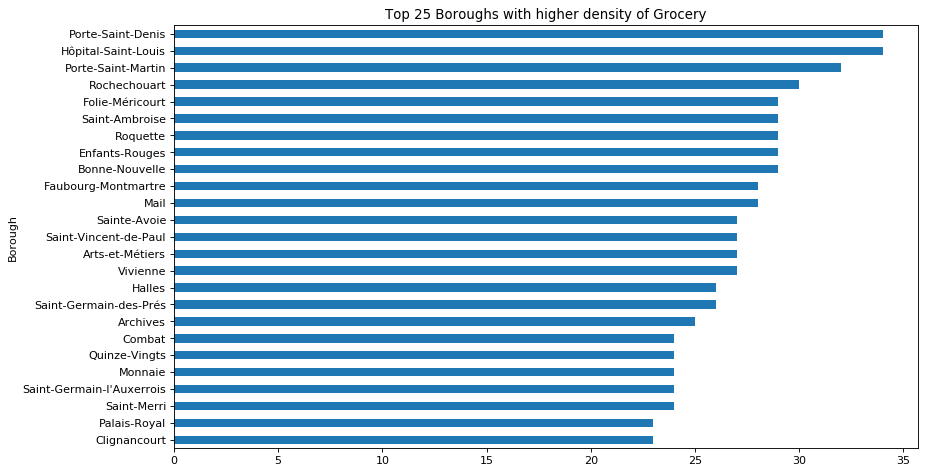

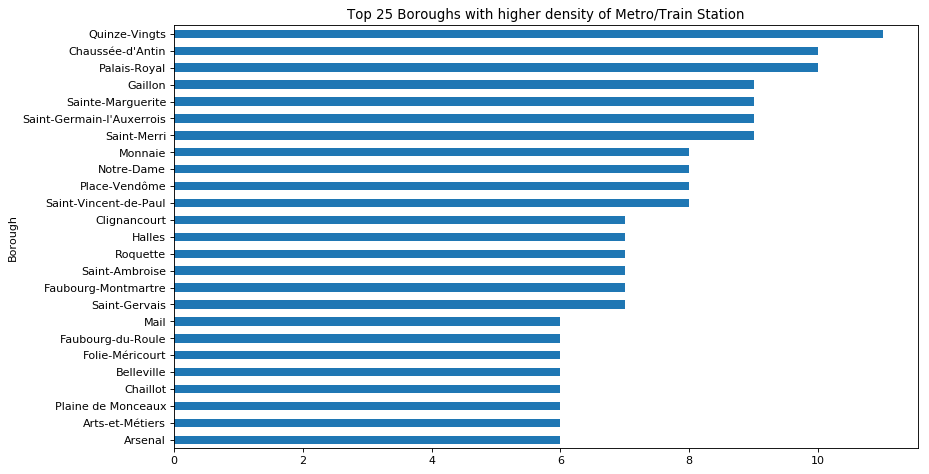

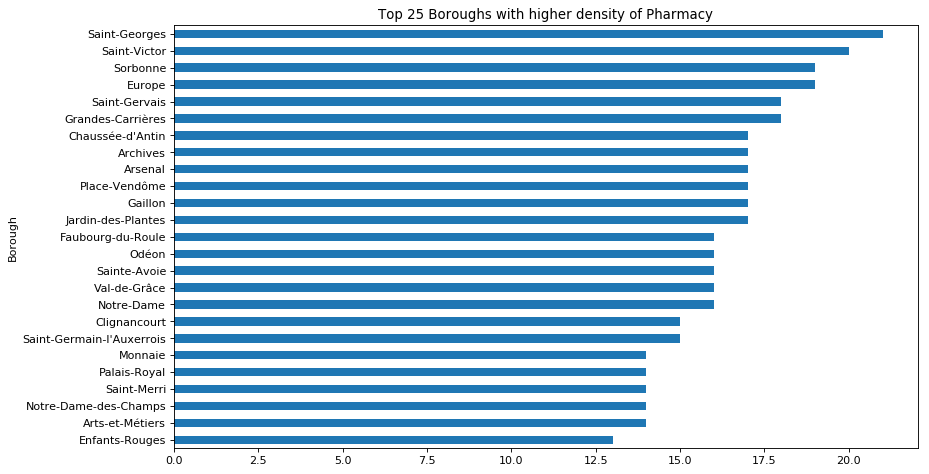

In [15]:
n = 25
plot_categories = ['Grocery', 'Metro/Train Station', 'Pharmacy']
for category in plot_categories:
    plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'Top {n} Boroughs with higher density of {category}')
    top_category_boroughs = venue_counts[category].sort_values(ascending=False)[0:n]
    top_category_boroughs = top_category_boroughs.sort_values(ascending=True)
    top_category_boroughs.plot.barh(y=category, rot=0)

We are going to visualize the data related to the venues in a folium map to formulate a first hypothesis about the boroughs that suit our criteria the most.

In [16]:
# Let's create a map with the limits of each parisian borough

m = folium.Map(location=[np.median(boroughs['centroid_lat'].tolist()),
                         np.median(boroughs['centroid_lon'].tolist())],
               tiles='Stamen Toner', zoom_start=11.6)

folium.GeoJson(boroughs, name='Borough Limits').add_to(m)

# We are going to add black circle markers representing the centroids of each borough 

fg = folium.FeatureGroup(name='Borough Info')
for clat, clon, name, in zip(boroughs['centroid_lat'].tolist(),
                             boroughs['centroid_lon'].tolist(),
                             boroughs['l_qu'].tolist()):
    html = f"""
    <b>{name}</b>
    """
    
    fg.add_child(folium.CircleMarker(location=[clat, clon], popup=html, radius=5, 
                                     color='black', fill=True, fill_color='black', 
                                     fill_opacity=0.8))

    m.add_child(fg)

# We will now add circle markers for each type of venue

fg = folium.FeatureGroup(cat='Venue Category')
for lat, lon, cat in zip(paris_venues_final['Venue Latitude'].tolist(),
                        paris_venues_final['Venue Longitude'].tolist(),
                        paris_venues_final['Venue Category'].tolist()):
    if cat == 'Grocery':
        folium.CircleMarker(location=[lat, lon], radius=3, color='yellow',
                            fill = True, fill_color='yellow', fill_opacity=0.6).add_to(fg)
    elif cat == 'Pharmacy':
        folium.CircleMarker(location=[lat,lon], radius=3, color='green',
                            fill=True, fill_color='green', fill_opacity=0.6).add_to(fg)
    else: # Every other venue marker is thus a metro or train station
        folium.CircleMarker(location=[lat, lon], radius=3, color='red',
                            fill=True, fill_color='red', fill_opacity=0.6).add_to(fg)

    m.add_child(fg)

def embed_map(m):
    from IPython.display import HTML

    m.save('index.html')
    with open('index.html') as f:
        html = f.read()

    iframe = '<iframe srcdoc="{srcdoc}" style="width: 100%; height: 750px; border: none"></iframe>'
    srcdoc = html.replace('"', '&quot;')
    return HTML(iframe.format(srcdoc=srcdoc))


embed_map(m)

/opt/conda/lib/python3.6/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


At glance we could say that northern and central boroughs look like the most crowded in venues specified by our client. We are going to check that premise through the machine learning algorithm of k-means clustering.

### Data preparation

Let's normalize the data using MinMaxScaler (scale from 0 to 1). This scales the data and provides an easy to interpret score at the same time.

In [17]:
from sklearn.preprocessing import MinMaxScaler

X = pd.DataFrame(venue_counts)
X = X.values
cluster_dataset = MinMaxScaler().fit_transform(X)

cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c for c in plot_categories]
cluster_df.head()

,Grocery,Metro/Train Station,Pharmacy
0,0.411765,0.090909,0.285714
1,0.735294,0.545455,0.809524
2,0.470588,0.545455,0.809524
3,0.794118,0.545455,0.666667
4,0.088235,0.090909,0.047619


### Clustering

We'll be using k-means clustering for our analysis. These were preliminary results with different number of clusters:

* 2 clusters only show the uptown/downtown divide of the boroughs
* 3 clusters give more accuracy to our model but is not divided enough
* 4 clusters also identify neighborhoods with very low density of venues and gives to our model more accuracy
* 5 clusters and more create more groups than needed for our general analysis 

For this data analysis we are going to use 4 clusters as we think is the number that might fit the most our dataset and the results we are looking for.

In [18]:

# Let's set number of clusters and run the k-means algorithm
kclusters = 4

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_

# Let's change label numbers so they go from highest scores to lowest

replace_labels = {0:2, 1:0, 2:3, 3:1}

for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

venue_clusters = venue_counts.copy()
venue_clusters['Cluster'] = kmeans_labels
venue_clusters_minmax_df = cluster_df.copy()
venue_clusters_minmax_df['Borough'] = pd.read_csv('boroughs.csv')['l_qu']
venue_clusters_minmax_df['Cluster'] = kmeans_labels
venue_clusters_minmax_df.head()

,Grocery,Metro/Train Station,Pharmacy,Borough,Cluster
0,0.411765,0.090909,0.285714,Amérique,0
1,0.735294,0.545455,0.809524,Archives,2
2,0.470588,0.545455,0.809524,Arsenal,2
3,0.794118,0.545455,0.666667,Arts-et-Métiers,1
4,0.088235,0.090909,0.047619,Auteuil,0


Let's use matplotlib library to create a boxplot to visualize the different clusters and see which one represents the boroughs with the highest density in venues specified by our client.

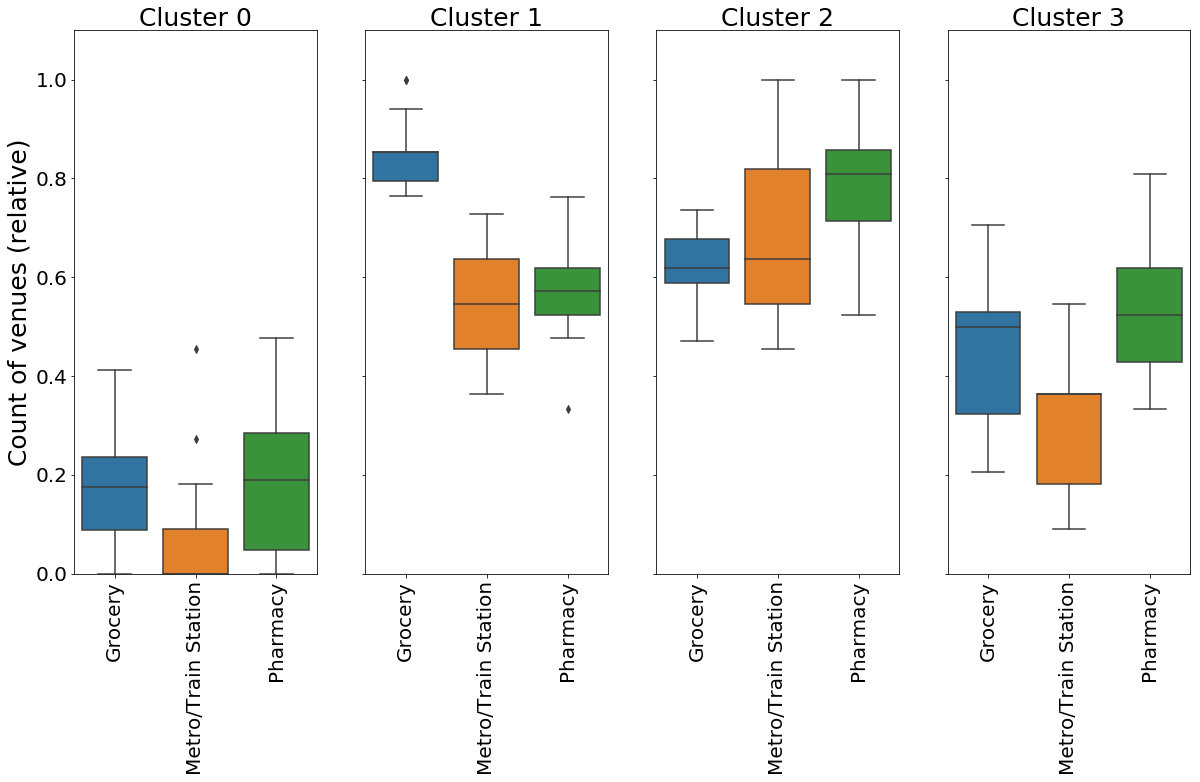

In [19]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1, kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)

for k in range(kclusters):
    # We are going to set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = venue_clusters_minmax_df[venue_clusters_minmax_df['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

As we can see in our boxplot the cluster of boroughs with higher density of the venues defined by our criteria is cluster number 2 and is followed by the cluster number 1. 

We are going to add to the previous dataframe the latitude and longitude coordinates of each borough so that we can represent them in a map created with Python's folium library.

In [20]:
venue_clusters_minmax_df['Latitude'] = pd.read_csv('boroughs.csv')['centroid_lat']
venue_clusters_minmax_df['Longitude'] = pd.read_csv('boroughs.csv')['centroid_lon']

Let's visualize the clustered neighbors in our new map. We will add circle markers to each borough centroid so that we can see how many venues are in each borough and to wich cluster it belongs to. 

* Cluster number 0 is represented by red
* Cluster number 1 is represented by orange 
* **Cluster number 2** is represented by **green**
* Cluster number 3 is represented by blue

In [21]:
m_clusters = folium.Map(location=[np.median(boroughs['centroid_lat'].tolist()),
                         np.median(boroughs['centroid_lon'].tolist())], 
                        tiles = 'Stamen Toner', zoom_start=11.6)

folium.GeoJson(boroughs, name='Borough Limits').add_to(m_clusters)

# Let's add markers for each borough

for i, borough, lat, lon, cluster, gr, ph, mt in zip(venue_clusters_minmax_df.index,
                                                     venue_clusters_minmax_df['Borough'],
                                                     venue_clusters_minmax_df['Latitude'],
                                                     venue_clusters_minmax_df['Longitude'],
                                                     venue_clusters_minmax_df['Cluster'],
                                                     pd.DataFrame(venue_counts)['Grocery'],
                                                     pd.DataFrame(venue_counts)['Pharmacy'],
                                                     pd.DataFrame(venue_counts)['Metro/Train Station']):  
    popup='<b>{}</b> is part of Cluster {} with {} groceries, {} pharmacies and {} metro or train/stations'.format(
        borough, cluster, gr, ph, mt)
    if cluster == 0:
        folium.CircleMarker(location=[lat,lon], radius=5, popup=folium.Popup(popup,max_width=300),
                           color='red', fill=True, fill_color='red', fill_opacity=0.6).add_to(m_clusters)
    elif cluster == 1:
        folium.CircleMarker(location=[lat,lon], radius=5, popup=folium.Popup(popup, max_width=300),
                           color='orange', fill=True, fill_color='orange', fill_opacity=0.6).add_to(m_clusters)
    elif cluster == 2:
        folium.CircleMarker(location=[lat,lon], radius=5, popup=folium.Popup(popup, max_width=300),
                           color='green', fill=True, fill_color='green', fill_opacity=0.6).add_to(m_clusters)
    else:
        folium.CircleMarker(location=[lat,lon], radius=5, popup=folium.Popup(popup, max_width=300),
                           color='blue', fill=True, fill_color='blue', fill_opacity=0.6).add_to(m_clusters)

# We are going to display the map containing the number of venues in each borough and the cluster they are part of

embed_map(m_clusters)

/opt/conda/lib/python3.6/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Results and Discussion <a name="results"></a>

The results in the map shown at the end of our analysis section confirm our first hypothesis after looking at the map representing with markers all the venues.

In our analysis we were looking for boroughs in Paris that had the highest number of groceries, pharmacies and metro and train stations because our client wanted to have the three of those venues nearby when deciding a borough to live in.

The central and northern boroughs seem to be the most crowded with the venues we picked for our analysis due to probably the higher development and higher population in the past and nowadays due to tourism as well for the central boroughs and the higher density of population nowadays in the north-western boroughs.

It would be interesting to look for a validation of our hypothesis of correlation between our results and the score of population or number of tourist attendance in each of the parisian boroughs. 

## Conclusion <a name="conclusion"></a>

We can conclude that our analysis shows us that there are more grocery, pharmacy, and metro stations venues in the central boroughs in overall as it might happen in other major cities in the world.

In the particular case of the city of Paris, some north-western boroughs are also show high density in those type of venues which might indicate that those areas are higher in population in comparison to other parisian boroughs.